In [1]:
%matplotlib inline

dataset mnist

In [2]:
from functools import reduce
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from PIL import Image
import matplotlib.pyplot as plt

print(torch.__version__)

0.4.0


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [5]:
batch_size = 64
train_set = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test_set = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)
train_loader = dataloader.DataLoader(train_set, **dataloader_args)
test_loader = dataloader.DataLoader(test_set, **dataloader_args)

In [6]:
def imshow_multi(images):
    f = plt.figure()
    for n, im in enumerate(images):
        im = np.clip(im, 0, 1)
        f.add_subplot(1, len(images), n+1)  # this line outputs images on top of each other
        # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
        fig = plt.imshow(im, cmap='gray', vmin=0, vmax=1)
        fig.axes.get_xaxis().set_visible(False) # this is the worst api in the world
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [7]:
img = train_set.train_data[4,:,:].numpy()
Image.fromarray(img)

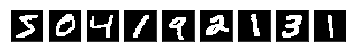

tensor([ 5,  0,  4,  1,  9,  2,  1,  3,  1])


In [8]:
imshow_multi(train_set.train_data[0:9,:,:].numpy())
print(train_set.train_labels[0:9])

## 定义神经网络


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16*4*4, 100) #TODO: 寻找自动匹配方法
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        """
        
        :param x: 一个batch的数据，输入结构：[batch_size, image_channel, image_width, image_height]
        :return: 前向传播结果
        """
        # 第一阶段特征提取（卷积、relu、池化）
        x = self.pool1(F.relu(self.conv1(x)))

        # 第二阶段特征提取（卷积、relu、池化）
        x = self.pool2(F.relu(self.conv2(x)))

        # dropout
        x = self.drop(x)

        # flat features 多维维空间一维化，输出也就是[batch_size, image_channel * image_width * image_height]
        x = x.view(-1, self.num_flat_features(x))
        # x = x.view(batch_size, -1)  不能用这种方法，因为最后一个epoch可能不是正好整除batch_size

        # 全连接层（fc1，fc2，fc3）
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return F.log_softmax(x)

    def num_flat_features(self, x):
        feature_size = x.size()[1:]
        num_flat = reduce(lambda m, n: m*n, feature_size, 1)
        return num_flat
    
net = Net()

## 定义损失函数

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)

In [11]:
train_losses = []
test_losses = []

def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(data)  # 输出结果outputs(batch_size, class_num)
        loss = criterion(outputs, target)  
        loss.backward()
        optimizer.step()

        if batch_idx % batch_size == 0:  # print every batch_size(64) mini-batches
            print('Train Epoch[{}]: Batch[{}/{} ({:.2%}%)]  Loss: {:.6}'.format(
                epoch, batch_idx * batch_size,
                len(train_loader.dataset), batch_size * batch_idx / len(train_loader.dataset),
                loss.data[0]
            ))
            train_losses.append(loss.data[0])


def test(epoch):
    """
    整体思路是：feed forward, 计算出预测的结果，然后统计预测的结果中正确的所占比例即为精度，
    在预测中不需要backward
    :param epoch: 
    :return: 
    """
    net.eval()
    correct = 0
    test_loss = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        outputs = net(data)
        test_loss += criterion(outputs, target).data[0]
        y_pred = outputs.data.max(1)[1]
#         correct += y_pred.eq(target.data).sum()
        correct += y_pred.eq(target.view_as(y_pred)).sum().item()
        

    avg_loss = test_loss / len(test_loader)  # loss function already averages over batch size
    print('\nTest  Epoch {}: Average loss: {:.6}, Accuracy:{:.6%}\n'.format(
        epoch, avg_loss, correct / len(test_loader.dataset)
    ))


for epoch in range(1, 5):
    train(epoch)
    test(epoch)

/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch[1]: Batch[0/60000 (0.00%%)]  Loss: 2.30417
Train Epoch[1]: Batch[4096/60000 (6.83%%)]  Loss: 2.29348
Train Epoch[1]: Batch[8192/60000 (13.65%%)]  Loss: 2.21694
Train Epoch[1]: Batch[12288/60000 (20.48%%)]  Loss: 1.58005
Train Epoch[1]: Batch[16384/60000 (27.31%%)]  Loss: 0.801477
Train Epoch[1]: Batch[20480/60000 (34.13%%)]  Loss: 0.899961
Train Epoch[1]: Batch[24576/60000 (40.96%%)]  Loss: 0.400018
Train Epoch[1]: Batch[28672/60000 (47.79%%)]  Loss: 0.558926
Train Epoch[1]: Batch[32768/60000 (54.61%%)]  Loss: 0.395587
Train Epoch[1]: Batch[36864/60000 (61.44%%)]  Loss: 0.287952
Train Epoch[1]: Batch[40960/60000 (68.27%%)]  Loss: 0.433122
Train Epoch[1]: Batch[45056/60000 (75.09%%)]  Loss: 0.180949
Train Epoch[1]: Batch[49152/60000 (81.92%%)]  Loss: 0.226135
Train Epoch[1]: Batch[53248/60000 (88.75%%)]  Loss: 0.334105
Train Epoch[1]: Batch[57344/60000 (95.57%%)]  Loss: 0.240022


/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test  Epoch 1: Average loss: 0.141171, Accuracy:95.360000%

Train Epoch[2]: Batch[0/60000 (0.00%%)]  Loss: 0.335009
Train Epoch[2]: Batch[4096/60000 (6.83%%)]  Loss: 0.271497
Train Epoch[2]: Batch[8192/60000 (13.65%%)]  Loss: 0.144494
Train Epoch[2]: Batch[12288/60000 (20.48%%)]  Loss: 0.218008
Train Epoch[2]: Batch[16384/60000 (27.31%%)]  Loss: 0.296075
Train Epoch[2]: Batch[20480/60000 (34.13%%)]  Loss: 0.145668
Train Epoch[2]: Batch[24576/60000 (40.96%%)]  Loss: 0.183861
Train Epoch[2]: Batch[28672/60000 (47.79%%)]  Loss: 0.110398
Train Epoch[2]: Batch[32768/60000 (54.61%%)]  Loss: 0.180479
Train Epoch[2]: Batch[36864/60000 (61.44%%)]  Loss: 0.0688071
Train Epoch[2]: Batch[40960/60000 (68.27%%)]  Loss: 0.1335
Train Epoch[2]: Batch[45056/60000 (75.09%%)]  Loss: 0.087973
Train Epoch[2]: Batch[49152/60000 (81.92%%)]  Loss: 0.292139
Train Epoch[2]: Batch[53248/60000 (88.75%%)]  Loss: 0.128316
Train Epoch[2]: Batch[57344/60000 (95.57%%)]  Loss: 0.0697112

Test  Epoch 2: Average loss: 0.

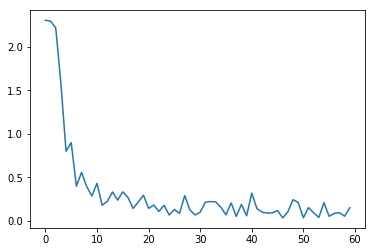

In [12]:
plt.plot(train_losses)

## 验证

In [14]:
a = test_set.test_data[0,:,:]
a = torch.unsqueeze(a,0)
a = torch.unsqueeze(a,0)
a = a.float()


In [16]:
output = net(a)
y_pred = output.data.max(1)[1]
y_pred

/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([ 7])

In [18]:
# 真值
test_set.test_labels[0]

tensor(7)

In [21]:
Image.fromarray(test_set.test_data[0,:,:].numpy())